In [140]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [141]:
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

In [142]:
import NaiveDE

In [143]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

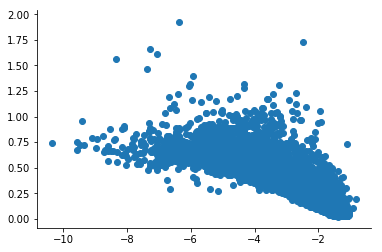

In [144]:
plt.scatter(res.mean(), res.var());

In [145]:
idx = res.var().sort_values(ascending=False).head(1000).index

In [146]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [147]:
pca = PCA()
Y = pca.fit_transform(scale(res[idx], 1))

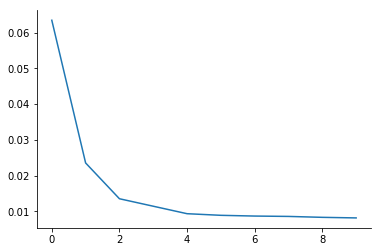

In [148]:
plt.plot(pca.explained_variance_ratio_[:10]);

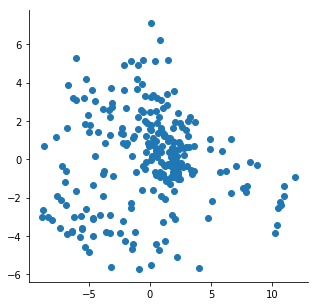

In [149]:
figsize(5, 5)
plt.scatter(Y[:, 0], Y[:, 1]);

In [150]:
from sklearn.mixture import BayesianGaussianMixture

In [151]:
gmm = BayesianGaussianMixture(n_components=20, max_iter=10000)

In [152]:
gmm.fit(Y[:, :2])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [153]:
phi_hat = gmm.predict(Y[:, :2])

In [154]:
sample_info['PC1'] = Y[:, 0]
sample_info['PC2'] = Y[:, 1]
sample_info['cluster'] = phi_hat

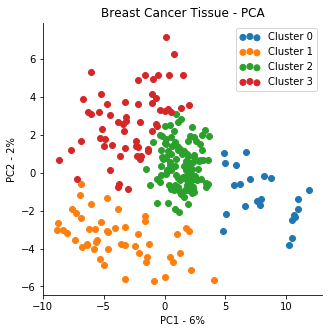

In [155]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.PC1, g.PC2, label=f'Cluster {i}')
    
plt.xlabel('PC1 - {:.0%}'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 - {:.0%}'.format(pca.explained_variance_ratio_[1]))

plt.legend(scatterpoints=3);
plt.title('Breast Cancer Tissue - PCA');
plt.savefig('PCA_MOB.pdf');

In [156]:
gmm

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

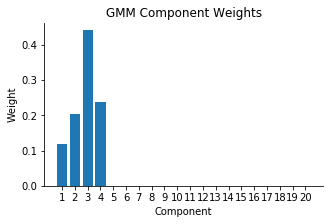

In [157]:
figsize(5, 3)
plt.bar(range(len(gmm.weights_)), gmm.weights_);
plt.title('GMM Component Weights');
plt.xticks(range(0, 20), range(1, 20 + 1));
plt.xlabel('Component')
plt.ylabel('Weight');
plt.savefig('gmm-weights.pdf')

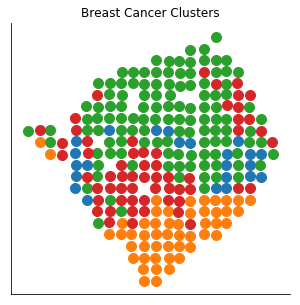

In [158]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.x, g.y, label=f'Cluster {i}', s=100)
    
plt.xticks([])
plt.yticks([]);
plt.axis('equal');
plt.title('Breast Cancer Clusters');
plt.savefig('bc_clusters.pdf');

In [159]:
sample_info['cluster'] = phi_hat

In [160]:
de_results = NaiveDE.lr_tests(sample_info, res.T, '~ C(cluster)')

In [161]:
de_results.query('qval < 0.05').shape

(952, 6)

In [162]:
de_results.shape

(12856, 6)

In [163]:
results = pd.read_csv('BC_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sde_results = results

In [164]:
de_results = de_results.sort_index()
sde_results = sde_results.sort_values('g')

In [198]:
sel_genes = ['CXCL13', 'CXCL9', 'IL12RB1', 'IL21R', 'SNAP25']

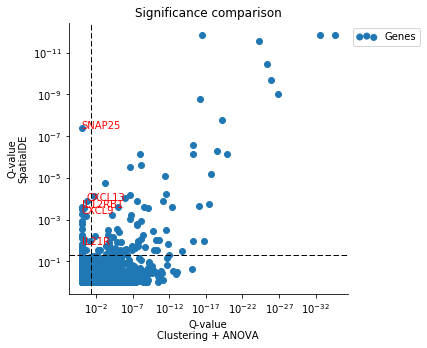

In [199]:
figsize(5, 5)

plt.loglog()
plt.scatter(de_results['qval'], sde_results['qval'], rasterized=True, label='Genes');

for g in sel_genes:
    gg = sde_results.query('g == @g')
    y = gg.iloc[0].qval
    x = de_results.loc[g].qval
    plt.annotate(g, (x, y), color='r')

ax = plt.gca()
ax.invert_yaxis()
ax.invert_xaxis();
plt.xlabel('Q-value\nClustering + ANOVA')
plt.ylabel('Q-value\nSpatialDE');

plt.axhline(0.05, color='k', ls='--', lw=1)
plt.axvline(0.05, color='k', ls='--', lw=1);

plt.legend(scatterpoints=3, bbox_to_anchor=[1, 1])

plt.title('Significance comparison')
plt.savefig('BC_significance_comparison.pdf', bbox_inches='tight')

In [166]:
sde_results.query('qval < 0.05').shape

(115, 18)

In [167]:
sig_genes = sde_results.query('qval < 0.05')['g'].sort_values().values
more_sig = de_results.loc[sig_genes].query('qval > 0.05').sort_values('qval')
more_sig

,Intercept,C(cluster)[T.1],C(cluster)[T.2],C(cluster)[T.3],pval,qval
FCGR3A,-2.938628,0.646656,0.235822,0.325429,0.000287,0.071661
CXCL13,-1.864511,0.095263,0.151028,0.321172,0.000714,0.178411
HPS3,-1.695469,-0.240100,-0.240670,-0.329972,0.001033,0.258189
IGFBP5,-6.574044,0.208071,-0.043988,-0.574082,0.001066,0.266402
TFF1,-1.879282,-0.350565,-0.170537,-0.244506,0.001569,0.392246
PI15,-1.380217,0.015058,0.069739,0.272317,0.001705,0.426317
SAA1,-1.726522,-0.252539,0.003806,0.234914,0.002428,0.607117
ITIH2,-2.787819,-0.369244,-0.056324,-0.106091,0.003086,0.771381
ACTL8,-1.647605,-0.298800,-0.131674,-0.249095,0.005515,1.000000
SLC16A6,-1.527314,-0.143842,-0.074819,-0.091121,0.064959,1.000000


In [168]:
more_sig.shape

(32, 6)

In [174]:
from gprofiler import gprofiler

In [176]:
GP_result = gprofiler(more_sig.index)

In [183]:
GP_result.sort_values('p.value')[['p.value', 'overlap.size', 'domain', 'term.name', 'intersection']]

,p.value,overlap.size,domain,term.name,intersection
term.id,,,,,
GO:0005615,0.0161,11,CC,extracellular space,"STC2,IGFBP5,GHRH,C2ORF40,CXCL9,ITIH2,CXCL13,TF..."
KEGG:04060,0.0163,4,keg,Cytokine-cytokine receptor interaction,"IL12RB1,IL21R,CXCL9,CXCL13"
OMIM:614072,0.0499,1,omi,HERMANSKY-PUDLAK SYNDROME 3; HPS3,HPS3
OMIM:614891,0.0499,1,omi,IMMUNODEFICIENCY 30; IMD30;;IL12RB1 DEFICIENCY,IL12RB1
OMIM:616330,0.0499,1,omi,"MYASTHENIC SYNDROME, CONGENITAL, 18; CMS18;...",SNAP25
OMIM:615947,0.0499,1,omi,"HYPERLIPOPROTEINEMIA, TYPE ID",GPIHBP1
OMIM:613951,0.0499,1,omi,"FANCONI ANEMIA, COMPLEMENTATION GROUP P; FANCP",SLX4
OMIM:616409,0.0499,1,omi,"EPILEPTIC ENCEPHALOPATHY, EARLY INFANTILE, ...",EEF1A2
OMIM:616393,0.0499,1,omi,"MENTAL RETARDATION, AUTOSOMAL DOMINANT 38; ...",EEF1A2


In [ ]:
plt.hist()

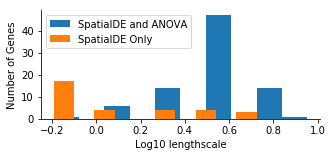

In [227]:
figsize(5, 2)
sde_results.query('qval < 0.05 & g not in @more_sig.index')['l'].pipe(np.log10).hist(grid=False, label='SpatialDE and ANOVA')
sde_results.query('g in @more_sig.index')['l'].pipe(np.log10).hist(grid=False, label='SpatialDE Only');
plt.legend(loc='upper left');
plt.xlabel('Log10 lengthscale');
plt.ylabel('Number of Genes');
plt.savefig('BC_lengthscale_hist.pdf')

In [169]:
sde_results.query('g in @more_sig.index')[['g', 'l', 'qval']].sort_values('qval')

,g,l,qval
7824,SNAP25,0.641736,4.121108e-08
8789,CXCL13,1.087806,1.277761e-04
9594,STC2,1.843940,2.500246e-04
8827,IL12RB1,1.087806,2.764643e-04
11263,PI15,3.125663,2.897039e-04
9926,SMYD1,1.843940,3.063606e-04
8463,CXCL9,1.087806,5.226403e-04
9020,IGFBP5,1.843940,6.902424e-04
7422,SSPO,0.641736,1.163649e-03
8036,ZNF880,0.641736,1.554445e-03


In [170]:
more_sig.shape

(32, 6)

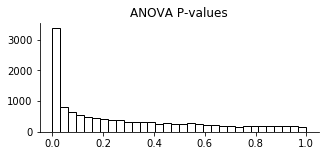

In [171]:
figsize(5, 2)
de_results.pval.hist(bins=32, fc='w', ec='k', grid=False);
plt.title('ANOVA P-values');

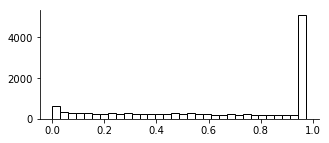

In [172]:
figsize(5, 2)
sde_results.pval.hist(bins=32, fc='w', ec='k', grid=False);

In [173]:
114 - 32

82